In [4]:
import numpy as np
import scipy
import scipy.stats

# Доверительные интервалы

ЦПТ с семинара

In [2]:
def get_95_interval(data, sigma=None):
    mean = data.mean()
    if sigma is None:
        sigma = data.std()
    err = sigma * 1.96 / np.sqrt(len(data))
    return mean - err, mean + err

Проверяем на больших выборках.

In [23]:
hits = 0.
count = 0.
true_mean = 0.5

for _ in range(10000):
    data = scipy.stats.bernoulli.rvs(0.5, size=1000)
    lower_bound, upper_bound = get_95_interval(data)
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(hits / count)

0.9455


Работает. Проверяем на маленьких.

In [25]:
hits = 0.
count = 0.
true_mean = 0.5

for _ in range(10000):
    data = scipy.stats.bernoulli.rvs(0.5, size=10)
    lower_bound, upper_bound = get_95_interval(data)
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(hits / count)

0.8895


Нет. К счастью, варианты оценки доверительного интервала описаны в Википедии, а реализация точной оценки - на гитхабе

In [41]:
def get_95_clopper_pearson(data):
    n = len(data)
    k = sum(data)
    return scipy.stats.beta.ppf(0.025, k, n-k+1), scipy.stats.beta.ppf(0.975, k+1, n-k)

In [44]:
hits = 0.
count = 0.
true_mean = 0.5

for _ in range(10000):
    data = scipy.stats.bernoulli.rvs(0.5, size=10)
    lower_bound, upper_bound = get_95_clopper_pearson(data)
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(hits / count)

0.9795


Оценка, как и предупреждает Википедия, является консервативной

Кроме того, есть пакет с этими интервалами

In [53]:
import statsmodels
import statsmodels.stats.proportion

In [54]:
hits = 0.
count = 0.
true_mean = 0.5

for _ in range(10000):
    data = scipy.stats.bernoulli.rvs(0.5, size=10)
    lower_bound, upper_bound = statsmodels.stats.proportion.proportion_confint(sum(data), len(data), alpha=0.05, method='normal')
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(hits / count)

0.8945


In [55]:
hits = 0.
count = 0.
true_mean = 0.5

for _ in range(10000):
    data = scipy.stats.bernoulli.rvs(0.5, size=10)
    lower_bound, upper_bound = statsmodels.stats.proportion.proportion_confint(sum(data), len(data), alpha=0.05, method='agresti_coull')
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(hits / count)

0.9776


In [56]:
hits = 0.
count = 0.
true_mean = 0.5

for _ in range(10000):
    data = scipy.stats.bernoulli.rvs(0.5, size=10)
    lower_bound, upper_bound = statsmodels.stats.proportion.proportion_confint(sum(data), len(data), alpha=0.05, method='wilson')
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(hits / count)

0.9788


# Bootstrap

In [61]:
import matplotlib.pyplot as plt

In [59]:
def my_bootstrap(data_fst, data_snd, iters=1000, plot=True):
    values = []
    for _ in range(iters):
        values.append(
            np.random.choice(data_fst, replace=True, size=len(data_fst)).mean()
            -
            np.random.choice(data_snd, replace=True, size=len(data_snd)).mean()
        )
        
    if plot:
        plt.hist(values, bins=30)
        plt.show()
        
    return np.percentile(values, [2.5, 97.5])

0.971833026449


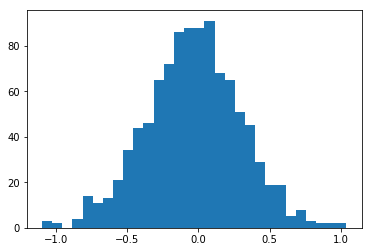

[-0.70507811  0.58944757]


In [62]:
data_fst = np.random.normal(0, 10, size=1000)
data_snd = np.random.normal(0, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_bootstrap(data_fst, data_snd, iters=1000, plot=True))

Корректность

In [104]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    lower, upper = my_bootstrap(data_fst, data_snd, plot=False, iters=1000)
    count += 1
    if not (lower < 0 < upper):
        hits += 1

print(hits / count)

0.061


Мощность

In [105]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    lower, upper = my_bootstrap(data_fst, data_snd, plot=False, iters=1000)
    count += 1
    if not (lower < 0 < upper):
        hits += 1

print(hits / count)

0.865


Корректность с выбросами

In [106]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.append(np.random.normal(10, 10, size=1000),[-1000000, -1000000])
    data_snd = np.random.normal(10, 1, size=100)

    lower, upper = my_bootstrap(data_fst, data_snd, plot=False, iters=1000)
    count += 1
    if not (lower < 0 < upper):
        hits += 1

print(hits / count)

0.186


Мощность с выбросами

In [107]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.append(np.random.normal(11, 10, size=1000),[-1000000, -1000000])
    data_snd = np.random.normal(10, 1, size=100)

    lower, upper = my_bootstrap(data_fst, data_snd, plot=False, iters=1000)
    count += 1
    if not (lower < 0 < upper):
        hits += 1

print(hits / count)

0.0


In [131]:
data_fst = np.append(np.random.normal(11, 10, size=1000),[-1000000, -1000000])
data_snd = np.random.normal(10, 1, size=100)
my_bootstrap(data_fst, data_snd, plot=False, iters=1000)

array([ -4.98883995e+03,   1.78915968e+00])

In [130]:
data_fst

array([  3.35965157e+00,   8.41760634e+00,   2.12124423e+01, ...,
         7.60743089e+00,  -1.00000000e+06,  -1.00000000e+06])

### Перестановочный тест

In [79]:
def my_test(data_fst, data_snd, iters=1000, plot=True):
    data = np.array(list(data_fst) + list(data_snd))
    size = len(data)
    values = []
    fst_ratio = len(data_fst) * 1. / size
    for _ in range(iters):
        mask = (np.random.random(size=size) < fst_ratio)
        values.append(data[mask].mean() - data[~mask].mean())
        
    if plot:
        plt.hist(values, bins=30)
        plt.show()
        
    return (np.abs(values) > np.abs(data_fst.mean() - data_snd.mean())).mean()

Корректность

In [80]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(10, 1, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

0.045


Мощность

In [81]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(11, 1, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

1.0


Корректность с выбросами

In [83]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.append(np.random.normal(10, 1, size=1000),[-1000000, -1000000])
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

0.0


Мощность с выбросами

In [84]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.append(np.random.normal(11, 1, size=1000),[-1000000, -1000000])
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

0.0


### Бутстреп показывает диаметрально противоположный истинному результат.

Бутстреп при одинаковых (за исключением выбросов) распределениях "теряет" возможность получить плавильную оценку нижней границы распределения (т.к. всегда попадаются случаи, когда в выборку попадают выбросы, т.е. левый край всегда смещен далеко налево). При этом оценка для правого края зависит от соотношения средних: если различие недостаточно велико или они равны, правый край иногда будет меньше нуля и тест покажет значительную ненулевую вероятность, что средние различны. Если же среднее по первой выборке существенно (с точки зрения теста) больше, то правый край будет также всегда больше нуля и тест зафиксирует равенство средних с высокой вероятностью.

### Перестановочный тест вседа показывает, что средние равны.

При семплинге новых подвыборок существует четыре состояния: оба выброса в первой подвыборке, оба выброса во второй подвыборке, один из выбросов в порвой подвыборке, друой - во второй (в двух комбинациях). Наблюдаемая ситуация соответствует первой ситуации. Перестановочный тест оценивает вероятность первой ситуации с учетом соотношения размеров выборок, ничего не показывая относительно других элементов, т.к. они вносят несравнимо меньший вклад в среднее.